First of all we are going to install a couple of libraries needed for interacting with Hugging Face. We are going to use HuggingFace for downloading a pretrained model and a dataset we will use for fine-tunning it.

- Lighting: PyTorch Lighting will provide a high-level interface for PyTorch, a popular machine learning framework.
- Datasets: A library for interacting with uploaded datasets available on the Hugging Face Hub.
- Transformers: A library for interacting with pre-trained models available on the Hugging Face Hub.

In [2]:
# !pip uninstall pigments

In [3]:
# !pip install lightning
# !pip install pigments
# !pip install transformers==4.23.1
# !pip install datasets==2.6.1
# !pip install huggingface-hub==0.11.1
# !pip install pytorch-lightning datasets transformers


In [4]:
# !python -V

In [5]:
# This is necessary only if we want our model to be uploaded into the hugging-face hub
# !huggingface-cli login

In [6]:
# !pip install lightning

In [7]:
import datasets
import lightning as pl
import matplotlib.pyplot as plt
import torch
from lightning import Trainer
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, ToPILImage
from transformers import AutoFeatureExtractor
from transformers import AutoModelForObjectDetection


In [8]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

import random
def xyxy_to_xcycwh(box):
    """
    Boxes in images may have the format (x1, y1, x2, y2) and we may need the format (center of x, center of y, width, height).
    :param box: Tensor-like box with format (x1, y1, x2, y2)
    :return: Tensor-like box with format (center of x, center of y, width, height)
    """
    x1, y1, x2, y2 = box.unbind(dim=1)
    width = x2-x1
    height = y2-y1
    xc = x1 + width*0.5
    yc = y1 + height*0.5
    b = [xc, yc, width, height]
    return torch.stack(b, dim=1)

def cxcywh_to_xyxy(x):
    """
    Boxes in images may have the format (center of x, center of y, width, height) and we may need the format (x1, y1, x2, y2).
    :param box: Tensor-like box with format (center of x, center of y, width, height)
    :return: Tensor-like box with format (x1, y1, x2, y2)
    """
    x_c, y_c, w, h = x.unbind(1)
    x1 = x_c - 0.5 * w
    y1 = y_c - 0.5 * h
    x2 = x_c + 0.5 * w
    y2 = y_c + 0.5 * h
    b = [x1, y1, x2, y2]
    return torch.stack(b, dim=1)

In [9]:
COLORS = ['lightcoral', 'yellowgreen', 'darkturquoise', 'hotpink', 'mediumslateblue']

def rescale_bboxes(out_bbox, size, down=True):
    """
    Boxes information contains values between 0 and 1 instead of values in pixels. This is made in order to make the boxes independant from the size of the image. But we may need to re-escale the box.
    """
    img_w, img_h = size
    if down:
        b = torch.Tensor(out_bbox) / torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    if not down:
        b = torch.Tensor(out_bbox) * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, boxes, class_labels):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for (xmin, ymin, xmax, ymax), c, label in zip(boxes, colors, class_labels):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        ax.text(xmin, ymin, str(label), fontsize=15,
                bbox=dict(facecolor=c, alpha=0.5))
    plt.axis('off')
    plt.show()

## Downloading and visualizing the fashionpedia dataset

In [10]:
# 95% Percent of the dataset will be used for training
train_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=0, to=95, unit="%", rounding="pct1_dropremainder"))
# 5% of the dataset will be used for validation
val_dataset = datasets.load_dataset("detection-datasets/fashionpedia", split=datasets.ReadInstruction("train",from_=95, to=100, unit="%", rounding="pct1_dropremainder"))

In [11]:
cats = train_dataset.features['objects'].feature['category']
cats

def idx_to_text(indexes):
    """
    Converts an index into a category label.
    :param indexes: List of indexes
    :return: List of category labels
    """
    labels = []
    for i in indexes:
        labels.append(cats.names[i])
    return labels

In [12]:
train_dataset

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 43320
})

In [13]:
val_dataset

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 2280
})

Plotting random item 7318


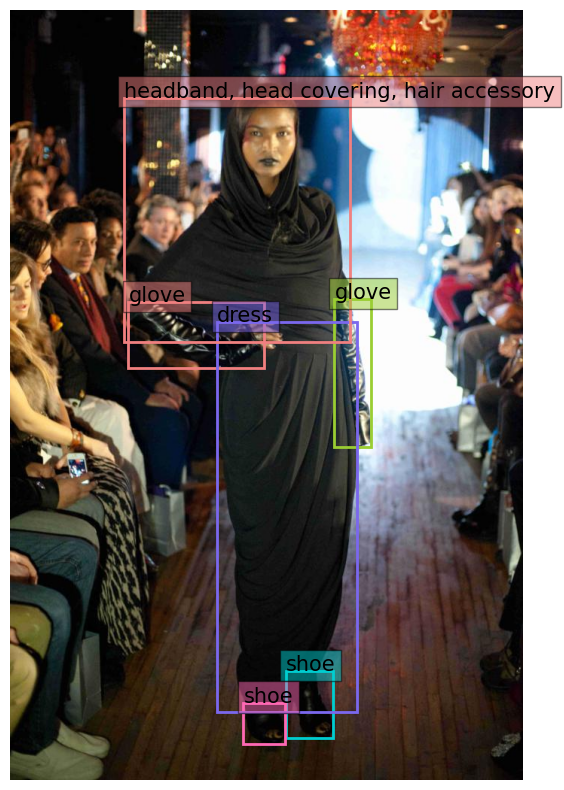

In [14]:
random_i = random.randint(0, train_dataset.num_rows)
print(f"Plotting random item {random_i}")
random_item = train_dataset[random_i]
plot_results(random_item['image'], random_item['objects']['bbox'], idx_to_text(random_item['objects']['category']))

### Preprocessing our dataset

In [15]:
# In order to use our images for the training, we're going to preprocess them, it is possible to use the YOLOs preprocessor.
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=816, max_size=864)

c:\Users\raiha\OneDrive\Desktop\AR-Shopping-Assistant\.venv\Lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [16]:
def transform(batch):
    inputs = {}
    image = batch['image']
    image = fix_channels(ToTensor()(image[0]))
    inputs['pixel_values'] = feature_extractor([image], return_tensors='pt')['pixel_values']
    labels = []
    bbox = [rescale_bboxes(batch['objects'][i]['bbox'], (batch['width'][i], batch['height'][i])) for i in range(len(batch['objects']))]
    bbox = [xyxy_to_xcycwh(torch.Tensor(bbox_i)) for bbox_i in bbox]
    labels.append({
        "boxes": bbox,
        "class_labels": [object['category'] for object in batch['objects']],
        "image_id": torch.Tensor([batch['image_id']]).int(),
        "area": [object['area'] for object in batch['objects']],
        "iscrowd": torch.Tensor([0 for _ in batch['objects']]).int(),
        "orig_size": torch.Tensor([(batch['width'], batch['height'])]).int(),
        "size": torch.Tensor([inputs['pixel_values'].shape[1:]])[0].int(),
    })
    inputs['labels'] = labels
    return inputs

In [17]:
prepared_train = train_dataset.with_transform(transform)
prepared_val = val_dataset.with_transform(transform)

In [18]:
def collate_fn(batch):
    collated = {}
    collated["pixel_values"] = feature_extractor.pad([item['pixel_values'] for item in batch], return_tensors="pt")['pixel_values']
    collated["labels"] = []
    for item in batch:
        item['labels']['boxes'] = torch.stack(item['labels']['boxes'])[0]
        item['labels']['area'] = torch.Tensor(item['labels']['area'])
        item['labels']['class_labels'] = torch.Tensor(item['labels']['class_labels'])[0]
        item['labels']['class_labels'] = item['labels']['class_labels'].type(torch.LongTensor)
        collated["labels"].append(item['labels'])
    return collated

In [19]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 43320
Number of validation examples: 2280


In [20]:
BATCH_SIZE = 1
train_dataloader = DataLoader(prepared_train, collate_fn=collate_fn, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(prepared_val, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [21]:
item = next(iter(train_dataloader))

In [22]:
item

{'pixel_values': tensor([[[[-0.2856, -0.3541, -0.5767,  ...,  0.1254,  0.2282,  0.2282],
           [-0.1143, -0.2684, -0.3541,  ...,  0.2111,  0.2967,  0.2282],
           [-0.0287, -0.3027, -0.3369,  ..., -0.1657, -0.0629, -0.1143],
           ...,
           [ 1.8893,  1.9064,  1.9407,  ...,  2.2147,  2.2318,  2.2318],
           [ 1.9578,  1.9920,  2.0263,  ...,  2.1633,  2.2318,  2.2489],
           [ 2.0092,  2.0434,  2.1119,  ...,  2.0434,  2.1975,  2.2489]],
 
          [[-0.1625, -0.2325, -0.4601,  ...,  0.2752,  0.3803,  0.3803],
           [ 0.0126, -0.1450, -0.2325,  ...,  0.3627,  0.4503,  0.3803],
           [ 0.0826, -0.1800, -0.2325,  ..., -0.0224,  0.0826,  0.0301],
           ...,
           [ 1.5882,  1.6057,  1.6232,  ...,  2.2185,  2.2360,  2.2360],
           [ 1.6057,  1.6232,  1.6758,  ...,  2.1310,  2.2185,  2.2185],
           [ 1.6057,  1.6583,  1.7283,  ...,  2.0084,  2.1660,  2.2360]],
 
          [[-0.4275, -0.4798, -0.6890,  ...,  0.2173,  0.3219,  0.3219

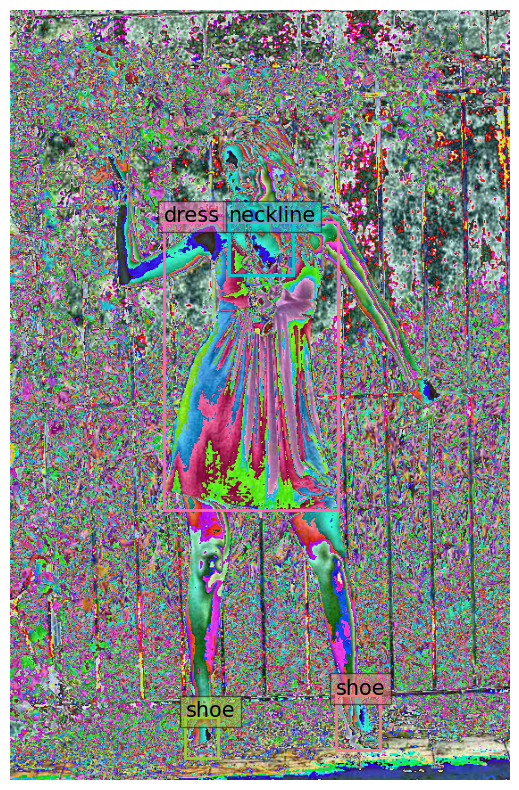

In [23]:
random_i = random.randint(0, BATCH_SIZE-1)
random_i = 0
pil_image = transforms.ToPILImage()(item['pixel_values'][random_i])
class_labels = item['labels'][random_i]['class_labels']
size = pil_image.size
boxes = rescale_bboxes(cxcywh_to_xyxy(item['labels'][random_i]['boxes']), size, down=False)
plot_results(pil_image, boxes, idx_to_text(class_labels.tolist()))

In [24]:
class Detr(pl.LightningModule):

     def __init__(self, lr, weight_decay):
         super().__init__()
         self.model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small",
                                                                  num_labels=cats.num_classes,
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.weight_decay = weight_decay

     def forward(self, pixel_values):
       outputs = self.model(pixel_values=pixel_values)
       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

Here we define the model, and verify the outputs.

In [25]:
model = Detr(lr=2.5e-5, weight_decay=1e-4)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([47]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([47, 384]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

Detr(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosSdpaAttention(
              (attention): YolosSdpaSelfAttention(
                (query): Linear(in_features=384, out_features=384, bias=True)
                (key): Linear(in_features=384, out_features=384, bias=True)
                (value): Linear(in_features=384, out_features=384, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=384, out_features=384, bias=True)
                (dropout

In [28]:
import torch

if torch.cuda.is_available():
    print("🔥 GPU is available:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU is not available.")


❌ GPU is not available.


In [ ]:
# Explicitly set the accelerator to CPU if GPU is not available
trainer = Trainer(max_epochs=1, accelerator="cpu")
trainer.fit(model)


MisconfigurationException: No supported gpu backend found!

In [ ]:
model

c:\Users\raiha\OneDrive\Desktop\AR-Shopping-Assistant\.venv\Lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:38: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

c:\Users\raiha\OneDrive\Desktop\AR-Shopping-Assistant\.venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\raiha\.cache\huggingface\hub\models--valentinafeve--yolos-fashionpedia. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


pytorch_model.bin:   0%|          | 0.00/123M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

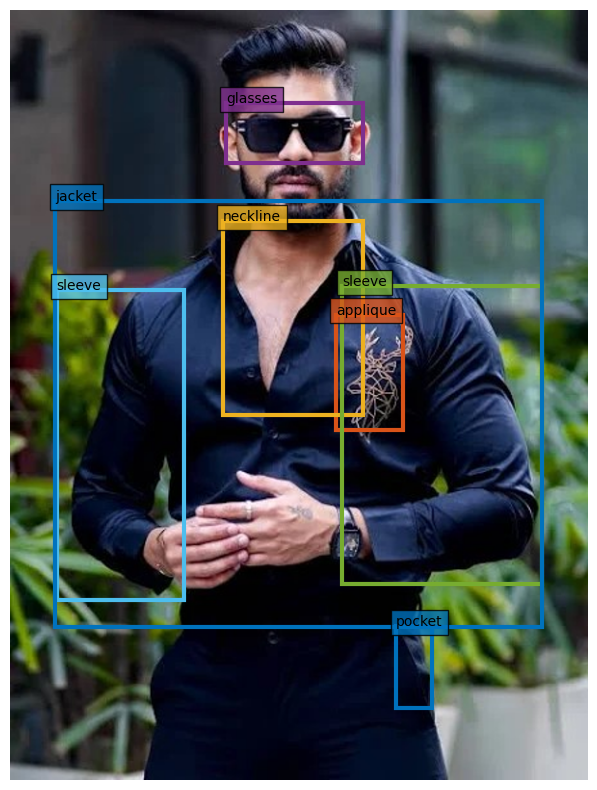

<Figure size 640x480 with 0 Axes>

In [1]:
# -*- coding: utf-8 -*-

from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

# Here you should put the path of your image
IMAGE_PATH =r"C:\Users\raiha\OneDrive\Desktop\AR-Shopping-Assistant\server\notebooks\shopping.jpg"

# This is the order of the categories list. NO NOT CHANGE. Just for visualization purposes
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

def idx_to_text(i):
    return cats[i]

# Random colors used for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        ax.text(xmin, ymin, idx_to_text(cl), fontsize=10,
                bbox=dict(facecolor=c, alpha=0.8))
    plt.axis('off')
    plt.show()
    plt.savefig("image.png")

def visualize_predictions(image, outputs, threshold=0.8):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

    # plot results
    plot_results(image, probas[keep], bboxes_scaled)

MODEL_NAME = "valentinafeve/yolos-fashionpedia"

feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)

image = Image.open(open(IMAGE_PATH, "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
image

"""Photo by <a href="https://unsplash.com/@reza_delkhosh_?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Reza Delkhosh</a> on <a href="https://unsplash.com/photos/iRAOJYtPHZE?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>

"""

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

img = visualize_predictions(image, outputs, threshold=0.5)
img

